In [ ]:
# Install torchaudio
!pip install torchaudio==0.9.1 -q
import librosa
import torchaudio
from torchaudio import transforms

In [122]:
import datetime
import os

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
from torch.utils.data import Dataset, DataLoader, IterableDataset

import numpy as np
import pandas as pd

from collections import Counter, defaultdict, OrderedDict

from sklearn.metrics import precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
IMG_PATH = '/content/drive/MyDrive/melSpectrogram'
AUD_PATH = '/content/drive/MyDrive/Annamayya'

## Basic Data cleanup operations

In [4]:
# Consider ragas that have at least 10 samples.
RAGAM_MIN_COUNT = 10

In [44]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
adata = pd.read_json('/content/drive/MyDrive/mp3_data_genres.json')

In [45]:
data['exists'] = data.apply(lambda x:os.path.exists(os.path.join(AUD_PATH,x['MP3 File'])),axis=1)
data = data[data.exists]

In [46]:
def get_offset(adata, id):
  l = adata[adata.Samputi==id]['Offset'].tolist()
  return 0 if len(l) == 0 else l[0]
data['Offset'] = data.apply(lambda x:get_offset(adata, x.Samputi), axis=1)

In [47]:
all_samples = data.Ragam.value_counts().index
low_samples = all_samples[data.Ragam.value_counts()<RAGAM_MIN_COUNT]
# Drop these rows.
for s in low_samples:
  data = data[data.Ragam!=s]

In [48]:
le = LabelEncoder()
le.fit_transform(data['Ragam'])
data['RagamCode'] = data.apply(lambda x:le.transform([x.Ragam])[0],axis=1)
n_labels = len(data['RagamCode'].unique())

In [115]:
data['Ragam'].value_counts()

లలిత            98
సాళంగనాట        94
సామంతం          89
బౌళి            70
శంకరాభరణం       68
శ్రీరాగం        65
రామక్రియ        61
ముఖారి          55
పాడి            50
ఆహిరి           45
దేసాళం          40
దేవగాంధారి      35
శుద్ధవసంతం      33
భూపాలం          32
దేసాక్షి        29
గుండుక్రియ      28
భైరవి           27
నాట             25
వరాళి           22
ధన్నాసి         20
మలహరి           20
కాంబోది         19
మాళవిగౌళ        18
మాళవి           18
కన్నడగౌళ        15
గుజ్జరి         15
గౌళ             14
బౌళిరామక్రియ    13
నాదరామక్రియ     11
సాళంగం          11
Name: Ragam, dtype: int64

In [103]:
print(f'Unique Ragas : {n_labels}')

Unique Ragas : 30


In [114]:
for c in le.classes_:
  print(f'{c} : {le.transform([c])}')

ఆహిరి : [0]
కన్నడగౌళ : [1]
కాంబోది : [2]
గుండుక్రియ : [3]
గుజ్జరి : [4]
గౌళ : [5]
దేవగాంధారి : [6]
దేసాక్షి : [7]
దేసాళం : [8]
ధన్నాసి : [9]
నాట : [10]
నాదరామక్రియ : [11]
పాడి : [12]
బౌళి : [13]
బౌళిరామక్రియ : [14]
భూపాలం : [15]
భైరవి : [16]
మలహరి : [17]
మాళవి : [18]
మాళవిగౌళ : [19]
ముఖారి : [20]
రామక్రియ : [21]
లలిత : [22]
వరాళి : [23]
శంకరాభరణం : [24]
శుద్ధవసంతం : [25]
శ్రీరాగం : [26]
సామంతం : [27]
సాళంగం : [28]
సాళంగనాట : [29]


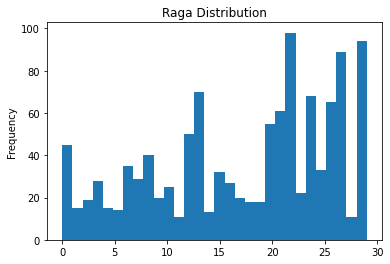

In [118]:
data['RagamCode'].plot.hist(bins=n_labels)
plt.title('Raga Distribution')
plt.show()

In [49]:
data['Offset'].fillna(60,inplace=True)

## Common functions that are needed for rest of notebook

In [24]:
def get_devices():
    if torch.cuda.is_available():
        gpu = torch.device("cuda")
    else:
        gpu = torch.device("cpu")
    cpu = torch.device("cpu")
    return gpu, cpu
gpu, cpu = get_devices()

In [25]:
def get_loss_function(balance_classes, labels, run_on, loss_fcn=nn.CrossEntropyLoss):
    if balance_classes:
        class_wts = compute_class_weight('balanced',
                                         np.unique(labels),
                                         labels
                                         )
        print(f'Class Weights : {class_wts}')
        # convert class weights to tensor
        weights = torch.tensor(class_wts, dtype=torch.float)
        weights = weights.to(run_on)
        # loss function
        loss_fcn = loss_fcn(weight=weights)
    else:
        loss_fcn = loss_fcn()
    return loss_fcn

In [26]:
def update_best_result(best_scores, valid_loss, train_labels, train_predictions, test_labels, test_predictions,
                       model=None, model_file_name=f'saved_weights_Fold_0.pt'):
    if valid_loss < best_scores['valid_loss']:
        best_scores['valid_loss'] = valid_loss
        best_scores['train_predictions'] = train_predictions
        best_scores['test_predictions'] = test_predictions
        best_scores['train_labels'] = train_labels
        best_scores['test_labels'] = test_labels
        if model:
            torch.save(model.state_dict(), model_file_name)
    return best_scores

In [27]:
def update_results_dict(results, train_labels, train_predictions, test_labels, test_predictions):
    s = 'micro'
    results['train_precision'].append(precision_score(train_labels, train_predictions,average=s))
    results['train_recall'].append(recall_score(train_labels, train_predictions,average=s))
    results['train_f1'].append(f1_score(train_labels, train_predictions,average=s))
    results['validation_precision'].append(precision_score(test_labels, test_predictions,average=s))
    results['validation_recall'].append(recall_score(test_labels, test_predictions,average=s))
    results['validation_f1'].append(f1_score(test_labels, test_predictions,average=s))
    return results

In [28]:
def run_model(model, dataset, loss_fcn, optimizer, is_training, run_on, clip_at=None, lstm_model=False, report_at=20):
  predict = lambda model, data, hidden: model(data, hidden) if hidden else model(data)
  hid = lambda model, data, run_on, lstm_model: model.init_hidden(data.shape[0], run_on) if lstm_model else None
  if is_training:
      print('Training Model')
      model.train()
  else:
      print('Evaluating Model')
      model.eval()
  total_loss, total_accuracy, model_predictions, model_labels, aud_data = 0, 0, [], [], None
  for step, batch in enumerate(dataset):
      if step % report_at == 0 and not step == 0:
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataset)))
      # push the batch to gpu
      batch = [r.to(run_on) for r in batch]        
      aud_data, labels = batch
      h = hid(model, aud_data, run_on, lstm_model)
      if is_training:
          for o in optimizer: o.zero_grad()
          model.zero_grad()
          predictions = predict(model, aud_data, h)
      else:
          with torch.no_grad():
            predictions = predict(model, aud_data, h)
      # compute the loss between actual and predicted values
      loss = loss_fcn(predictions, labels)
      predictions = predictions.detach().cpu().numpy()
      total_loss = total_loss + loss.item()
      if is_training:
          loss.backward()  # backward pass to calculate the gradients
          if clip_at:
              torch.nn.utils.clip_grad_norm_(model.parameters(), clip_at)
          # update parameters
          for o in optimizer: o.step()
      # append the model predictions
      model_predictions.append(predictions)
      model_labels.append(labels.detach().cpu().numpy())
      del batch
  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataset)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  model_predictions = np.concatenate(model_predictions, axis=0)
  model_labels = np.concatenate(model_labels, axis=0)
  # returns the loss and predictions
  model_predictions = np.argmax(model_predictions, axis=1)
  return avg_loss, model_predictions, model_labels, model

In [29]:
def plot_results(results, model_name):
    fig = plt.figure(figsize=[20, 10])
    epochs = len(results[0]['train_precision'])
    x_label = f'{len(results)} Fold and {epochs} Epochs'
    legend_labels = ['Train', 'Val']

    def subplot_routine(key1, key2, title, loss=False):
        plt.plot([x for k in results for x in results[k][key1]])
        plt.plot([x for k in results for x in results[k][key2]])
        plt.grid()
        plt.xlabel(x_label)
        plt.legend([f'{x} {title}' for x in legend_labels])
        if not loss:
            plt.ylim([0, 1.1])
        else:
            b, t = plt.ylim()
            plt.ylim(np.floor(b), np.ceil(t))

    gs = GridSpec(2, 3, figure=fig)
    plt.subplot(gs.new_subplotspec((0, 0), colspan=3))
    subplot_routine('train_losses', 'validation_losses', 'Losses', True)
    plt.subplot(2, 3, 4)
    subplot_routine('train_precision', 'validation_precision', 'Precision')
    plt.subplot(2, 3, 5)
    subplot_routine('train_recall', 'validation_recall', 'Recall')
    plt.subplot(2, 3, 6)
    subplot_routine('train_f1', 'validation_f1', 'F1')
    plt.suptitle(f'Metrics for {model_name}')
    plt.tight_layout()
    plt.show()

In [67]:
class AbsDataset(IterableDataset):
  def __init__(self):
    super().__init__()
  
  def get_data_loader(self, batch_size=32, random_seed=42):
    g = torch.Generator()
    g.manual_seed(random_seed)
    return DataLoader(self, batch_size=batch_size, generator=g)

In [65]:
def train_model(data, prepare_data_hnd, gpu, **kwargs):
  torch.manual_seed(42)
  start_time = datetime.datetime.now()

  n_labels = kwargs['n_labels']
  title = kwargs['title']
  report = kwargs['report'] if 'report' in kwargs else 20
  lstm = kwargs['lstm'] if 'lstm' in kwargs else False
  lr = kwargs['lr'] if 'lr' in kwargs else 1e-4
  clip_at = kwargs['clip_at'] if 'clip_at' in kwargs else None
  k_folds = kwargs['k_folds'] if 'k_folds' in kwargs else 5
  balance_classes = kwargs['balance_classes'] if 'balance_classes' in kwargs else True
  dropout = kwargs['dropout'] if 'dropout' in kwargs else 0.25
  plot = kwargs['plot'] if 'plot' in kwargs else True
  epochs = kwargs['epochs'] if 'epochs' in kwargs else 5
  
  k_fold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
  results = {x: {} for x in range(k_folds)}
  labels = data['RagamCode']
  for fold, (train_ids, test_ids) in enumerate(k_fold.split(data[['mfcc_mean']], data['RagamCode'])):
    print(f'FOLD {fold} \n Data Sizes (Train/Test) : {len(train_ids)}/{len(test_ids)}')
    fold_start = datetime.datetime.now()
    # empty lists to store training and validation loss of each epoch
    train_losses, valid_losses = [], []
    best_scores = {'valid_loss': float('inf'),
                    'train_predictions': [],
                    'test_predictions': [],
                    'train_labels': [],
                    'test_labels': []
                    }
    # for each epoch
    results[fold] = {
        'train_f1': [],
        'validation_f1': [],
        'train_precision': [],
        'validation_precision': [],
        'train_recall': [],
        'validation_recall': []
    }
    train_data, test_data, train_lbls, test_lbls = prepare_data_hnd(data, train_ids, test_ids)
    model = kwargs['model'](n_labels,dropout=dropout)
    model.to(gpu)
    loss_fcn = get_loss_function(balance_classes, data['RagamCode'].tolist(), gpu, nn.CrossEntropyLoss)
    # define the optimizer
    optimizer = [torch.optim.Adam(model.parameters(), lr=lr)]
    lr_schedulers = [ReduceLROnPlateau(optimizer[0], patience=3,factor=0.1,threshold=1e-9,mode='min'),
                     ExponentialLR(optimizer[0],gamma=0.9)]
    for epoch in range(epochs):
        e_start = datetime.datetime.now()
        print('Epoch {:} / {:}'.format(epoch + 1, epochs))
        # train model
        train_loss, train_predictions, train_labels, model = run_model(model, train_data.get_data_loader(batch_size=32),
                                                                        loss_fcn, optimizer, run_on=gpu,
                                                                        is_training=True, clip_at=clip_at,
                                                                       lstm_model=lstm, report_at=report)
        # evaluate model
        valid_loss, test_predictions, test_labels, model = run_model(model, test_data.get_data_loader(batch_size=32),
                                                                      loss_fcn, optimizer, run_on=gpu,
                                                                      is_training=False, clip_at=clip_at,
                                                                     lstm_model=lstm, report_at=report)
        print(f'Losses - Train : {train_loss:.3f} / Validation : {valid_loss:.3f}')
        for lr_scheduler in lr_schedulers:
            lr_scheduler.step(valid_loss)
        torch.cuda.empty_cache()
        # save the best model
        best_scores = update_best_result(best_scores,
                                          valid_loss,
                                          train_labels, train_predictions,
                                          test_labels, test_predictions,
                                          model=model,
                                          model_file_name=f'saved_weights_Fold_{fold}.pt')
        # append training and validation loss
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        results[fold] = update_results_dict(results[fold],
                                            train_labels, train_predictions,
                                            test_labels, test_predictions)
        e_end = datetime.datetime.now()
        print(f'Time for epoch : {(e_end - e_start).total_seconds()} seconds')
    print('On Train Data')
    print(classification_report(best_scores['train_labels'], best_scores['train_predictions']))
    print('On Test Data')
    print(classification_report(best_scores['test_labels'], best_scores['test_predictions']))
    results[fold]['train_losses'] = train_losses
    results[fold]['validation_losses'] = valid_losses
    print(f'Time for fold {fold} : {(datetime.datetime.now() - fold_start).total_seconds()} seconds')
  end_time = datetime.datetime.now()
  print(f'Overall Time : {(end_time - start_time).total_seconds()} seconds')
  print('*** Confusion Matrix - Training ***')
  print(confusion_matrix(train_predictions,train_labels))
  print('*** Confusion Matrix - Validation ***')
  print(confusion_matrix(test_predictions,test_labels))
  if plot:
    plot_results(results, title)
  return results

# Experiment 1 - Using Mean levels of MFCC Values
40 MFCC levels are precomputed using MATLAB
## Experiment 1.1 - Feed forward model

In [68]:
class MfccDataset(AbsDataset):
    def __init__(self, labels, mfcc_vals):
        super().__init__()
        self.labels = labels
        self.mfcc_vals = mfcc_vals

    def __len__(self):
        return len(self.labels)

    def __iter__(self):
        for index, _ in enumerate(self.labels):
            yield self.mfcc_vals[index][1:], self.labels[index]

    def __getitem__(self, index):
        return self.mfcc_vals[index][1:], self.labels[index]

    @staticmethod
    def prepare_data(data, train_ids, test_ids):
      train_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in train_ids])
      test_lbls = torch.tensor([data['RagamCode'].iloc[x] for x in test_ids])
      train_vals = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in train_ids])
      test_vals = torch.tensor([[_ for _ in data['mfcc_mean'].iloc[x]] for x in test_ids])
      train_data = MfccDataset(train_lbls, train_vals)
      test_data = MfccDataset(test_lbls, test_vals)
      return train_data, test_data, train_lbls, test_lbls

In [93]:
class MfccFtVecRaga(nn.Module):
    def __init__(self, n_labels, dropout=0.25):
        super().__init__()
        self.n_labels = n_labels
        self.mfcc = nn.Sequential(
            nn.Linear(40, 80), nn.GELU(),
            nn.Linear(80, 160), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(160, 320), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(320, self.n_labels)
        )
        
    def forward(self,x):
        return self.mfcc(x)

FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.461 / Validation : 3.422
Time for epoch : 0.081468 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.437 / Validation : 3.434
Time for epoch : 0.079848 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.398 / Validation : 3.461
Time for epoch : 0.086402 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.377 / Validation : 3.476
Time for epoch : 0.090803 seconds
Epoch 5 / 10

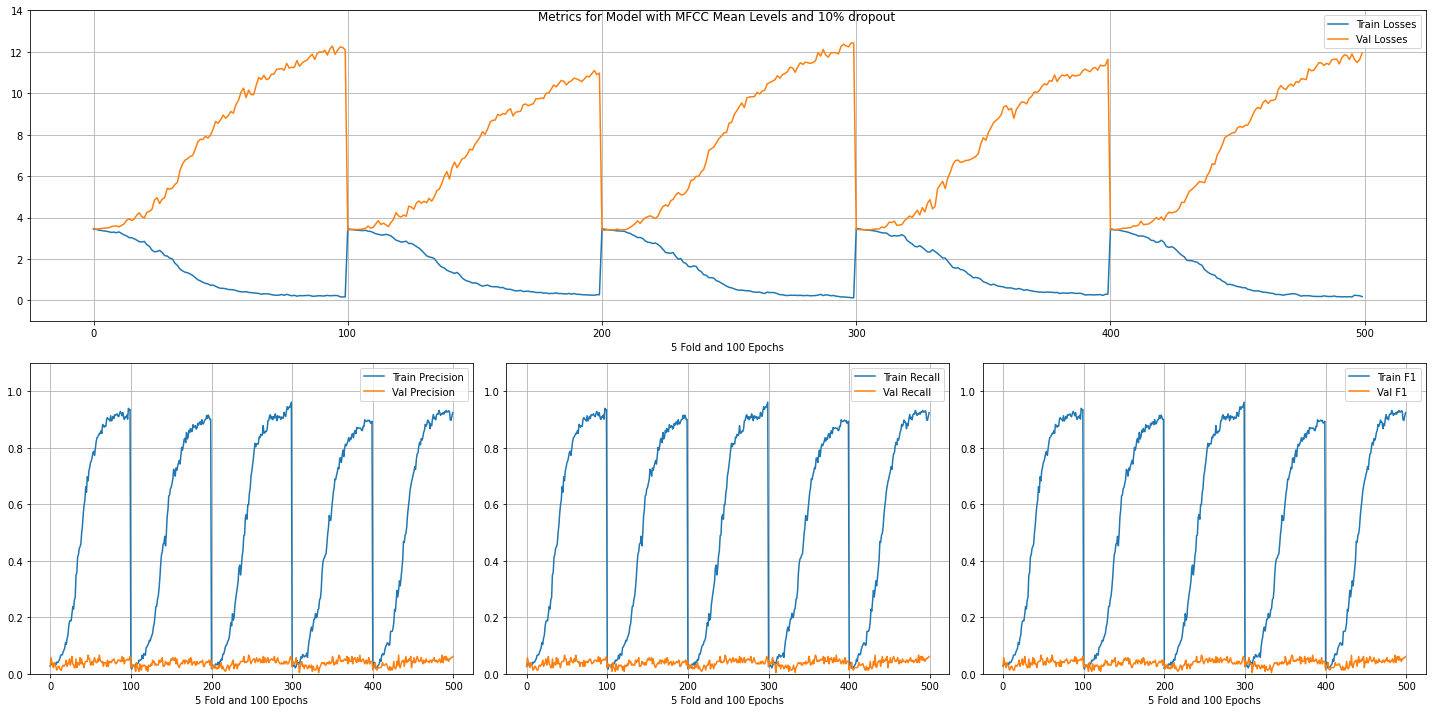

In [100]:
mfcc_single_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.1,
                                   'title' : 'Model with MFCC Mean Levels and 10% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.472 / Validation : 3.420
Time for epoch : 0.0799 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.427 / Validation : 3.434
Time for epoch : 0.082971 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.395 / Validation : 3.467
Time for epoch : 0.08508 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.387 / Validation : 3.455
Time for epoch : 0.085301 seconds
Epoch 5 / 100
T

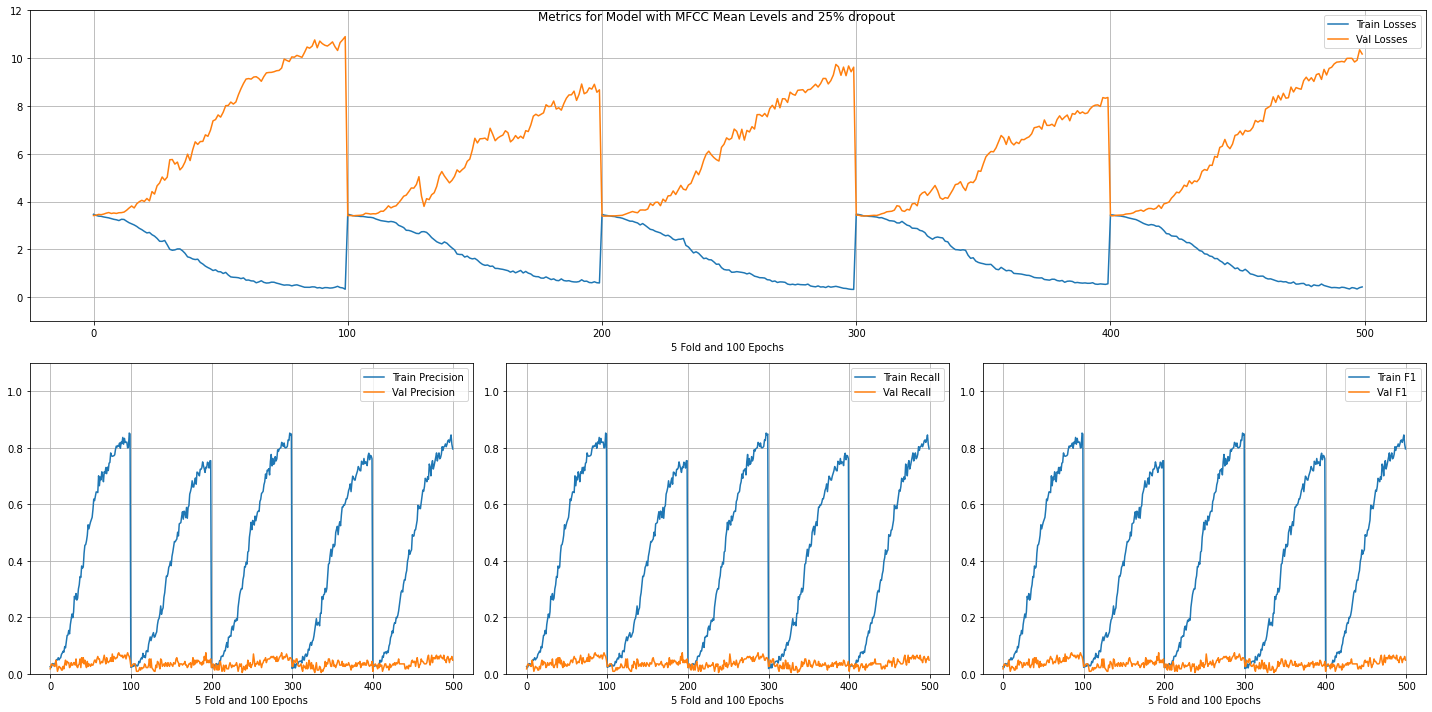

In [101]:
mfcc_single_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.25,
                                   'title' : 'Model with MFCC Mean Levels and 25% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

FOLD 0 
 Data Sizes (Train/Test) : 912/228
Class Weights : [0.84444444 2.53333333 2.         1.35714286 2.53333333 2.71428571
 1.08571429 1.31034483 0.95       1.9        1.52       3.45454545
 0.76       0.54285714 2.92307692 1.1875     1.40740741 1.9
 2.11111111 2.11111111 0.69090909 0.62295082 0.3877551  1.72727273
 0.55882353 1.15151515 0.58461538 0.42696629 3.45454545 0.40425532]
Epoch 1 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.480 / Validation : 3.412
Time for epoch : 0.079303 seconds
Epoch 2 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.427 / Validation : 3.431
Time for epoch : 0.08028 seconds
Epoch 3 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.413 / Validation : 3.429
Time for epoch : 0.086446 seconds
Epoch 4 / 100
Training Model
  Batch    20  of     29.
Evaluating Model
Losses - Train : 3.385 / Validation : 3.445
Time for epoch : 0.083976 seconds
Epoch 5 / 100

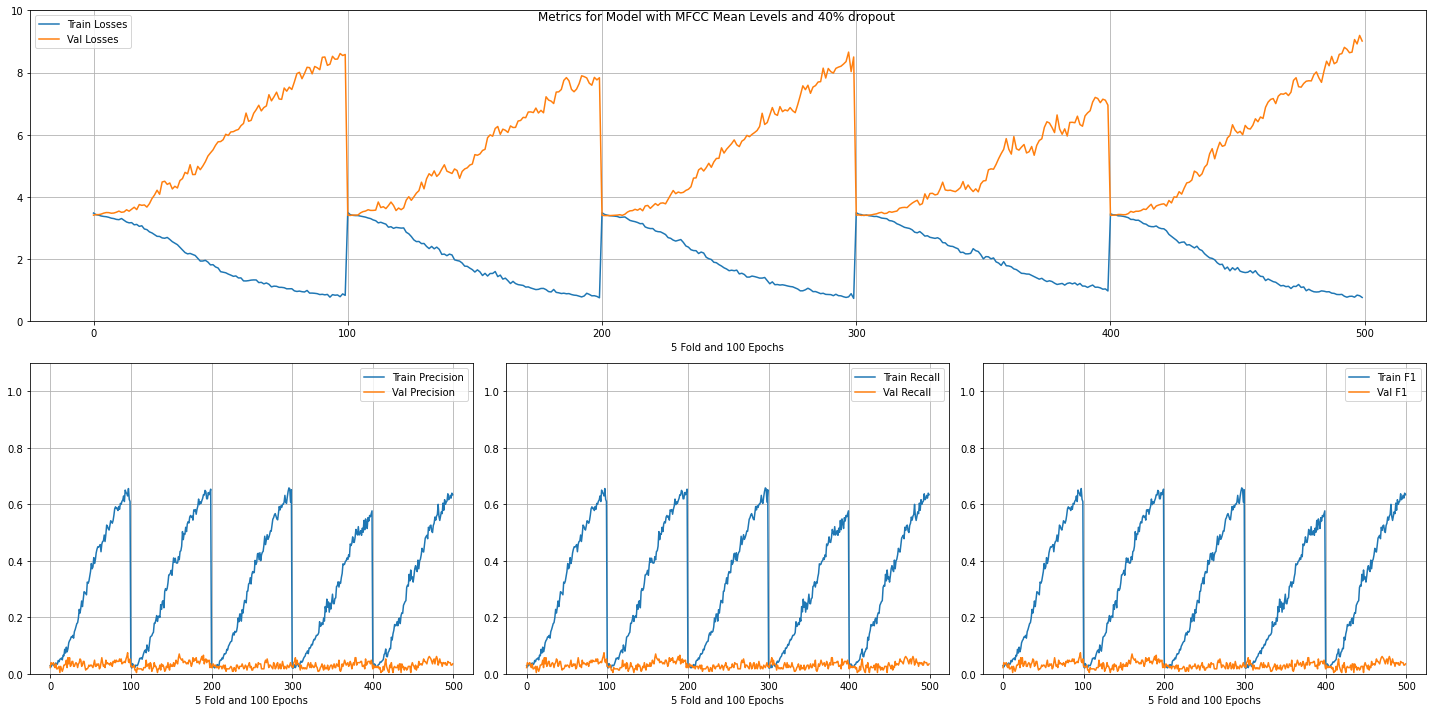

In [102]:
mfcc_single_results = train_model(data, MfccDataset.prepare_data, gpu, 
                                  **{'n_labels' : n_labels,
                                   'report' : 20,
                                   'lstm' : False,
                                   'lr' : 5e-3,
                                   'clip_at' : None,
                                   'k_folds' : 5,
                                   'balance_classes' : True,
                                   'dropout' : 0.4,
                                   'title' : 'Model with MFCC Mean Levels and 40% dropout',
                                   'plot' : True,
                                   'epochs' : 100,
                                   'model' : MfccFtVecRaga})

## Experiment 1.2 - ML Models

In [164]:
from sklearn.preprocessing import MinMaxScaler

from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from functools import reduce

In [172]:
def do_grid_search(_X,_y,mdl,params,scoring,key,n=5):
    pipe = Pipeline([('scaler', MinMaxScaler()), ('mdl', mdl)])
    nparams = {f'mdl__{k}':params[k] for k in params}
    est = GridSearchCV(pipe,nparams,scoring=scoring,cv=n,return_train_score=True,refit=key,n_jobs=-1)
    est.fit(_X,_y)
    return est

In [159]:
def plot_grid_results(est,keys,title):
    plt.figure(figsize=[12,3])
    for i,k in enumerate(keys):
        train_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_train_{k}'] for x in range(est.cv)])
        test_score = reduce(lambda a,b: list(a) + list(b), [est.cv_results_[f'split{x}_test_{k}'] for x in range(est.cv)])
        plt.subplot(1,len(keys),i+1)
        plt.plot(train_score)
        plt.plot(test_score)
        plt.legend(['Train','Test'])
        plt.ylim([0,1.1])
        plt.grid()
        plt.title(k)
    plt.suptitle(title, y=1.0)
    plt.tight_layout(h_pad=1)
    plt.show()

In [123]:
scorers = {
    'Precision' : make_scorer(precision_score,average='micro'),
    'Recall' : make_scorer(recall_score,average='micro'),
    'F1_Score' : make_scorer(f1_score,average='micro'),
          }

In [167]:
RAND_STATE = 42
Models = {
    'Multi Nomial Naive Bayes Classification': (MultinomialNB(),{'alpha':[1e-3,1e-4,1e-5]}),
    'Bernoulli Naive Bayes Classification': (BernoulliNB(),{'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'Complement Naive Bayes Classification': (ComplementNB(),{'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'Logistic Regression' : (LogisticRegression(random_state=RAND_STATE),{'tol':[1e-1,1e-3,1e-4,1e-5]}),
    'Nearest Centroid Classification': (NearestCentroid(),{}),
    'Ridge Classifier': (RidgeClassifier(random_state=RAND_STATE), {'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'SGD Classifier': (SGDClassifier(random_state=RAND_STATE),{'alpha':[1e-1,1e-3,1e-4,1e-5]}),
    'Linear SVC': (LinearSVC(random_state=RAND_STATE),{'tol':[1e-2,1e-4,1e-1]}),
    'Random Forest Classifier': (RandomForestClassifier(random_state=RAND_STATE),{'min_samples_leaf':[2,5,10]}),
    'XGB Classifier': (XGBClassifier(use_label_encoder=True),{'eta':[0.1,0.3,0.5],'objective':['binary:logistic']}),
}

In [146]:
def run_kfold(n, Models, X, y):
    Res = {}
    for k in Models:
        print(f'Model {k}')
        Res[k] = do_grid_search(X,y,Models[k][0],Models[k][1],scorers,'F1_Score',n)
        print('Mean F1 Score : ' ,100*Res[k].best_score_, '%')
        plot_grid_results(Res[k],list(scorers.keys()),f'{n} Fold {k}')
    return Res

In [160]:
X = pd.DataFrame()
for i in range(1,41):
  # MATLAB Produces 41 element MFCC vectors of which 1st element shall be ignored.
  X[i] = data.apply(lambda x:x['mfcc_mean'][i], axis=1)
y = data.apply(lambda x:x['RagamCode'], axis=1)

Model Multi Nomial Naive Bayes Classification
Mean F1 Score :  9.12280701754386 %


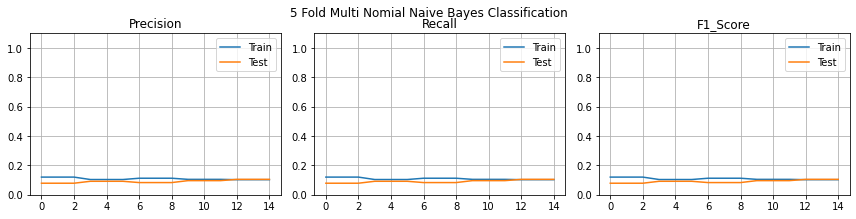

Model Bernoulli Naive Bayes Classification
Mean F1 Score :  8.421052631578947 %


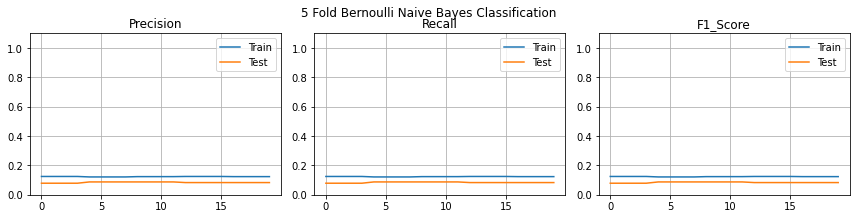

Model Complement Naive Bayes Classification
Mean F1 Score :  5.7894736842105265 %


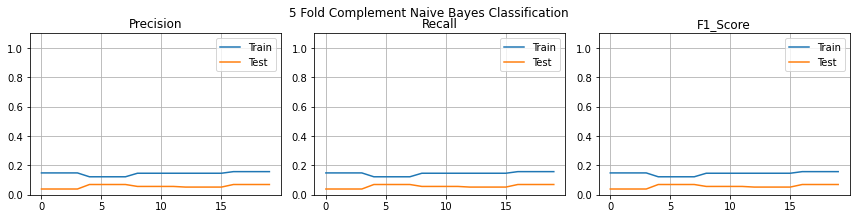

Model Logistic Regression
Mean F1 Score :  7.368421052631578 %


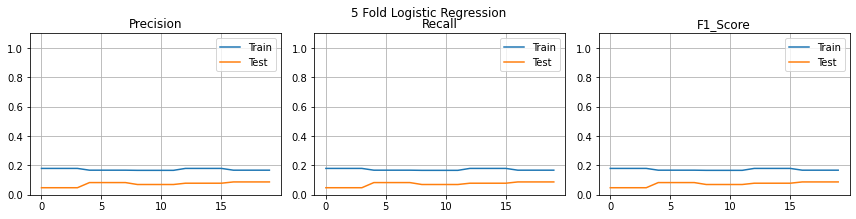

Model Nearest Centroid Classification
Mean F1 Score :  2.631578947368421 %


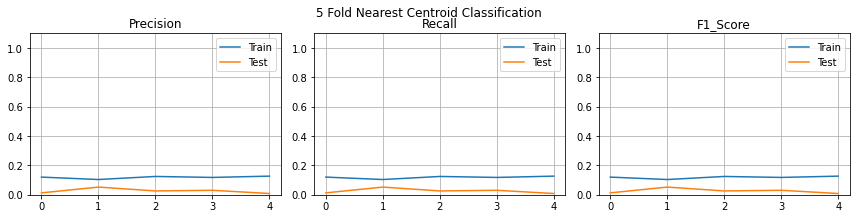

Model Ridge Classifier
Mean F1 Score :  7.456140350877193 %


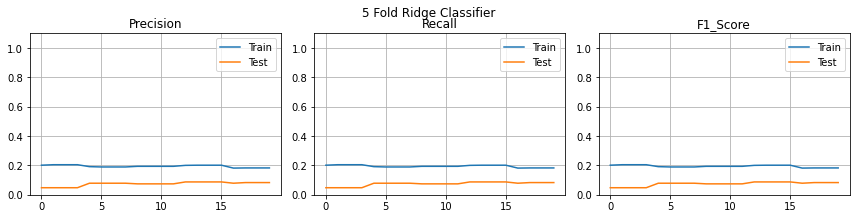

Model SGD Classifier
Mean F1 Score :  4.824561403508771 %


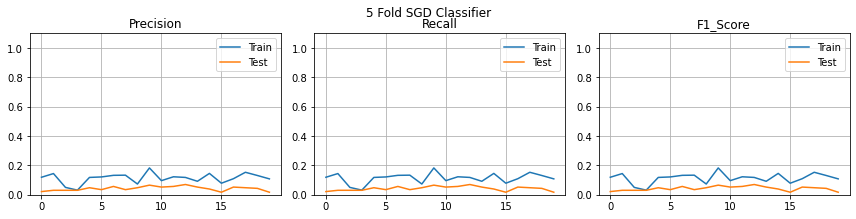

Model Linear SVC
Mean F1 Score :  6.666666666666667 %


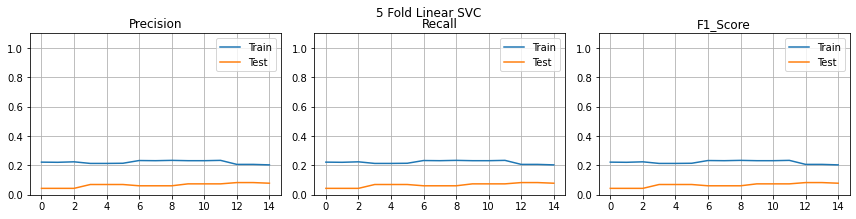

Model Random Forest Classifier
Mean F1 Score :  8.333333333333332 %


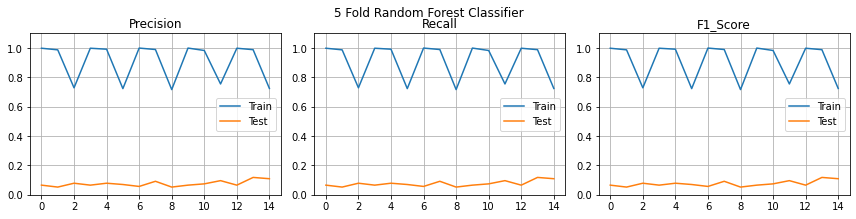

Model XGB Classifier
Mean F1 Score :  6.491228070175439 %


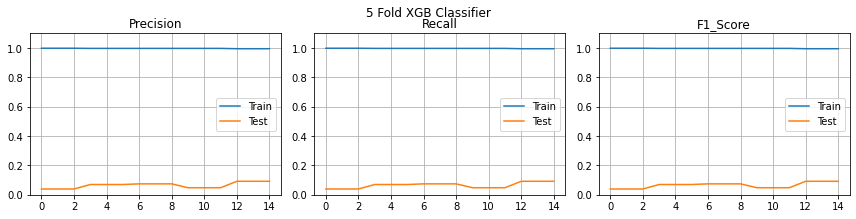

In [173]:
Results = {}
Results['5Fold'] = run_kfold(5, Models, X, y)

# Experiment 2 - Using 40 MFCC Values for 120 sec duration of each song
## Experiment 2.1 - Using Feed forward model